In [2]:
import torch
from pytorch_modular import data_setup, engine, loaders, Plot_metrics

from torchvision import transforms
from pathlib import Path

In [4]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "cat_dog_data"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    #image_path.mkdir(parents=True, exist_ok=True)
print(image_path)


data\cat_dog_data directory exists.
data\cat_dog_data


In [5]:
train_dir = image_path/"train"
val_dir = image_path/"val"
test_dir = image_path/"test"

print(train_dir)
print(val_dir)
print(test_dir)

data\cat_dog_data\train
data\cat_dog_data\val
data\cat_dog_data\test


In [6]:
# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
torch.manual_seed(52)
torch.cuda.manual_seed_all(52)

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# test_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Mean and std for normalization
# ])


In [8]:
train_dataset, val_dataset, test_dataset = data_setup.load_dataset(data_type="train_val_test", data_dir= None, train_dir= train_dir,
                 val_dir= val_dir, test_dir = test_dir, train_transform=transform, val_transform=transform)

print("Train:", len(train_dataset))
print("val:",len(val_dataset))
print("test:",len(test_dataset))

Train: 24000
val: 3001
test: 3000


In [9]:
print("Train:", train_dataset[0][0].shape)
print("Train:", val_dataset[0][0].shape)
print("Train:", test_dataset[0][0].shape)

Train: torch.Size([3, 224, 224])
Train: torch.Size([3, 224, 224])
Train: torch.Size([3, 224, 224])


torch.Size([3, 224, 224])


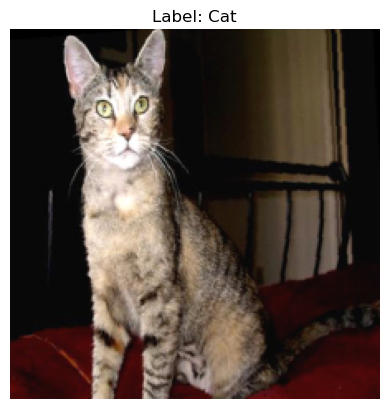

In [10]:
import matplotlib.pyplot as plt
# Get a batch of images
data_iter = iter(train_dataset)
images, labels = next(data_iter)  # Get the first batch of images and labels

print(images.shape)

# Define the transformation to convert a tensor to a PIL image
to_pil_image = transforms.ToPILImage()

# Convert the tensor image to a PIL image
pil_image = to_pil_image(images)

# Display the PIL image using matplotlib
plt.imshow(pil_image)
plt.title(f"Label: {train_dataset.classes[labels]}")
plt.axis('off')  # Hide axes
plt.show()

In [11]:
class_names = train_dataset.classes
class_names

['Cat', 'Dog']

In [12]:
# Setup hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 64
#HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

In [13]:
# Define DataLoaders
train_loader, val_loader, test_loader= loaders.create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE)
print("Train:", len(train_loader))
print("val:",len(val_loader))
print("test:",len(test_loader))

Train: 375
val: 47
test: 47


In [15]:
# Create model with help from model_builder.py
import torch.nn as nn
class dog_cat_classify(nn.Module):
    def __init__(self):
        super(dog_cat_classify, self).__init__()

        # Define convolutional layers
        self.layer1 = self.ConvModule(in_features=3, out_features=32)
        self.layer2 = self.ConvModule(in_features=32, out_features=64)
        self.layer3 = self.ConvModule(in_features=64, out_features=128)
        
        # Define fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(512, 2)  # For 2 classes
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.classifier(x)
        return x
    
    def ConvModule(self, in_features, out_features):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.MaxPool2d(2, 2,padding=0)  # Pooling reduces size by half
        )

In [16]:

# Initialize model, loss function, and optimizer
model = dog_cat_classify().to(device)
print(model)

dog_cat_classify(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352,

In [17]:
# Set loss and optimizer
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9,weight_decay=0.01) # ,weight_decay=0.01
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [18]:
from tqdm.auto import tqdm
import time

# Early stopping parameters
patience = 5
delta = 0.01
best_accuracy = 0.0
early_stop_counter = 0

# Results dictionary
results = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "test_loss": [],
    "test_acc": []
}

# Start training
start_time = time.time()

named_tuple = time.localtime()  # get struct_time
time_string = time.strftime("%m/%d/%Y, %H:%M:%S", named_tuple)
print(time_string)

for epoch in tqdm(range(NUM_EPOCHS)):
    # Training phase
    all_labels, all_predictions, train_loss, train_acc = engine.train(
        model=model,
        dataloader=train_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        device=device
    )
    
    # Validation phase
    all_labels, all_predictions, val_loss, val_acc = engine.evaluate(
        model=model,
        dataloader=val_loader,
        loss_fn=criterion,
        device=device
    )
    
    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)

    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"val_loss: {val_loss:.4f} | "
        f"val_acc: {val_acc:.4f}"
    )

    # Scheduler step
    # If using a scheduler that steps per epoch
    #scheduler.step()

    # If using a scheduler like ReduceLROnPlateau
    # scheduler.step(val_loss)  # Uncomment this line if using ReduceLROnPlateau

    # Check if the validation accuracy has improved
    if val_acc > best_accuracy + delta:
        best_accuracy = val_acc
        print("this is epoch", epoch)
        early_stop_counter = 0
        # Save the model with the best accuracy
        torch.save(model.state_dict(), 'cat_dog_best_ckpoint_new.pt')
    else:
        early_stop_counter += 1

    # Check if early stopping should be triggered
    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

# Compute and print the total training time
end_time = time.time()
print(f"Training completed in {(end_time - start_time) / 60:.2f} minutes") 

D:\anaconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


09/03/2024, 00:11:17


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5751 | train_acc: 0.6922 | val_loss: 0.5262 | val_acc: 0.7318
this is epoch 0


 10%|█         | 1/10 [09:01<1:21:15, 541.69s/it]

Epoch: 2 | train_loss: 0.4959 | train_acc: 0.7531 | val_loss: 0.4913 | val_acc: 0.7547
this is epoch 1


 20%|██        | 2/10 [13:26<50:30, 378.77s/it]  

Epoch: 3 | train_loss: 0.4605 | train_acc: 0.7772 | val_loss: 0.4559 | val_acc: 0.7887
this is epoch 2


 30%|███       | 3/10 [34:19<1:30:45, 777.98s/it]

Epoch: 4 | train_loss: 0.4344 | train_acc: 0.7931 | val_loss: 0.4213 | val_acc: 0.8067
this is epoch 3


 40%|████      | 4/10 [37:58<55:43, 557.22s/it]  

Epoch: 5 | train_loss: 0.4094 | train_acc: 0.8091 | val_loss: 0.3924 | val_acc: 0.8234
this is epoch 4


 60%|██████    | 6/10 [44:34<23:19, 349.87s/it]

Epoch: 6 | train_loss: 0.3838 | train_acc: 0.8254 | val_loss: 0.3749 | val_acc: 0.8317


 70%|███████   | 7/10 [47:43<14:52, 297.40s/it]

Epoch: 7 | train_loss: 0.3713 | train_acc: 0.8312 | val_loss: 0.4441 | val_acc: 0.7957
Epoch: 8 | train_loss: 0.3600 | train_acc: 0.8390 | val_loss: 0.3615 | val_acc: 0.8441
this is epoch 7


 90%|█████████ | 9/10 [56:47<04:45, 285.35s/it]

Epoch: 9 | train_loss: 0.3523 | train_acc: 0.8434 | val_loss: 0.5221 | val_acc: 0.7641


100%|██████████| 10/10 [1:01:38<00:00, 369.83s/it]

Epoch: 10 | train_loss: 0.3360 | train_acc: 0.8515 | val_loss: 0.3709 | val_acc: 0.8371


Training completed in 61.65 minutes


In [19]:
best_accuracy

0.8440519826724425